In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/01 16:12:12 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/11/01 16:12:14 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_1269/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'sum', 'max', 'min', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
# df_trigg_MK_SOHO = spark.read.table('b2b_stg.df_churn_weekly_scoring_v04')
df_trigg_MK_SOHO = spark.read.table('b2b_stg.df_churn_weekly_scoring_v06_shmk')

df_trigg_MK_SOHO = df_trigg_MK_SOHO.filter(F.col('week_of_year') == 43)

print('num_rows:', df_trigg_MK_SOHO.count())
df_trigg_MK_SOHO.printSchema()

# num_rows: 1 145 826

num_rows: 1145826
root
 |-- subscriber_sk: long (nullable = true)
 |-- woe_calls_sum_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4: double (nullable = true)
 |-- woe_gprs_mb_3_HR_avg_relative_change_lag0_1: double (nullable = true)
 |-- woe_voice_min_1to2_HR_avg_relative_change_lag0_1: double (nullable = true)
 |-- preds_trig_model: double (nullable = true)
 |-- interp_woe_calls_sum_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_voice_min_2_HR_avg_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_voice_min_1_HR_avg_ratio_mean_lag0_2_4: string (nullable = true)
 |-- interp_woe_gprs_mb_3_HR_avg_relative_change_lag0_1: string (nullable = true)
 |-- interp_woe_voice_min_1to2_HR_avg_relative_change_lag0_1: string (nullable = true)
 |-- preds_trig_model_norm: double (nullable = true)
 |-- subscriber_num: string (nullable = true)
 |-- account_typ

In [6]:
# df_ML = spark.read.table('b2b_stg.df_churn_ML_score_week_42') 
df_ML = spark.read.table('b2b_stg.df_churn_ML_score_week_43') 

print('num_rows:', df_ML.count())
df_ML.printSchema()

# num_rows: 4 857 045
# num_cols: 29

num_rows: 4857045
root
 |-- subscriber_sk: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- gprs_mb_3_H_avg_gr30_sum: integer (nullable = true)
 |-- gprs_mb_3_H_avg: float (nullable = true)
 |-- voice_min_1_H_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_R_avg: float (nullable = true)
 |-- voice_min_2_H_avg_gr30_sum: integer (nullable = true)
 |-- price_plan_type_max_Other: integer (nullable = true)
 |-- active_days_sum: float (nullable = true)
 |-- price_plan_type_max_Bundle: integer (nullable = true)
 |-- voice_min_2_H_avg: float (nullable = true)
 |-- voice_min_2_R_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_H_avg: float (nullable = true)
 |-- good_days_sum: float (nullable = true)
 |-- accept_days_sum: float (nullable = true)
 |-- bad_days_sum: float (nullable = true)
 |-- voice_min_1_R_avg_gr30_sum: integer (nullable = true)
 |-- repr2q2025_max: float (nullable = true)
 |-- subs_market_cd_vip: float (nullable = true)
 |-- voice_mi

In [7]:
# df = df_trigg_MK_SOHO.join(df_ML[['subscriber_sk', 'week_of_year', 'score_ML']], how = 'left', on = ['subscriber_sk', 'week_of_year'])

df = df_trigg_MK_SOHO[['subscriber_sk', 'week_of_year']].join(df_ML, how = 'left', on = ['subscriber_sk', 'week_of_year'])

print('num_rows:', df.count())
df.printSchema()

# num_rows: 1 145 826

num_rows: 1145826
root
 |-- subscriber_sk: long (nullable = true)
 |-- week_of_year: long (nullable = true)
 |-- gprs_mb_3_H_avg_gr30_sum: integer (nullable = true)
 |-- gprs_mb_3_H_avg: float (nullable = true)
 |-- voice_min_1_H_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_R_avg: float (nullable = true)
 |-- voice_min_2_H_avg_gr30_sum: integer (nullable = true)
 |-- price_plan_type_max_Other: integer (nullable = true)
 |-- active_days_sum: float (nullable = true)
 |-- price_plan_type_max_Bundle: integer (nullable = true)
 |-- voice_min_2_H_avg: float (nullable = true)
 |-- voice_min_2_R_avg_gr30_sum: integer (nullable = true)
 |-- voice_min_1_H_avg: float (nullable = true)
 |-- good_days_sum: float (nullable = true)
 |-- accept_days_sum: float (nullable = true)
 |-- bad_days_sum: float (nullable = true)
 |-- voice_min_1_R_avg_gr30_sum: integer (nullable = true)
 |-- repr2q2025_max: float (nullable = true)
 |-- subs_market_cd_vip: float (nullable = true)
 |-- voice_min_2_R_

In [8]:
df_pd = df.toPandas()

df_pd.to_pickle('df_trig_ml_week_43.pkl')

In [9]:
df_pd = pd.read_pickle('df_trig_ml_week_43.pkl')

print(df_pd.shape)
df_pd.head(3)

# num_rows: 1 145 826

(1145826, 29)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,voice_min_2_R_avg,price_plan_type_max_Line,subs_market_cd_ekt,gprs_mb_3_R_avg_gr30_sum,subs_market_cd_kzn,price_plan_type_max_Data,subs_market_cd_ufa,subs_market_cd_spb,calls_sum,score_ML
0,2221,43,0,2442.348389,2,0.000000,2,0,4.0,1,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.002001
1,4901,43,0,258.087158,1,0.000000,2,0,6.0,1,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.006584
2,33608,43,1,3506.158691,1,0.429167,1,0,7.0,1,...,0.0,0,0.0,0,0.0,0,1.0,0.0,0.0,0.010087


In [10]:
df_pd['score_ML'].isna().sum()

0

In [11]:
# df_pd['preds_trig_model'].isna().sum()

In [12]:
# 26
model_features = ['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 'calls_sum'
]

print(len(model_features))

26


In [13]:
# *************** save model 15.10.25: *****************

# with open('model_churn_not_balanced.pkl', 'wb') as fid:
#         pickle.dump(clf_lgb, fid)

# ********************** read: ***********************

with open('model_churn_not_balanced.pkl', 'rb') as fid:
    clf_lgb = pickle.load(fid)

##### Shap test

/home/ezagaynaya/.local/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


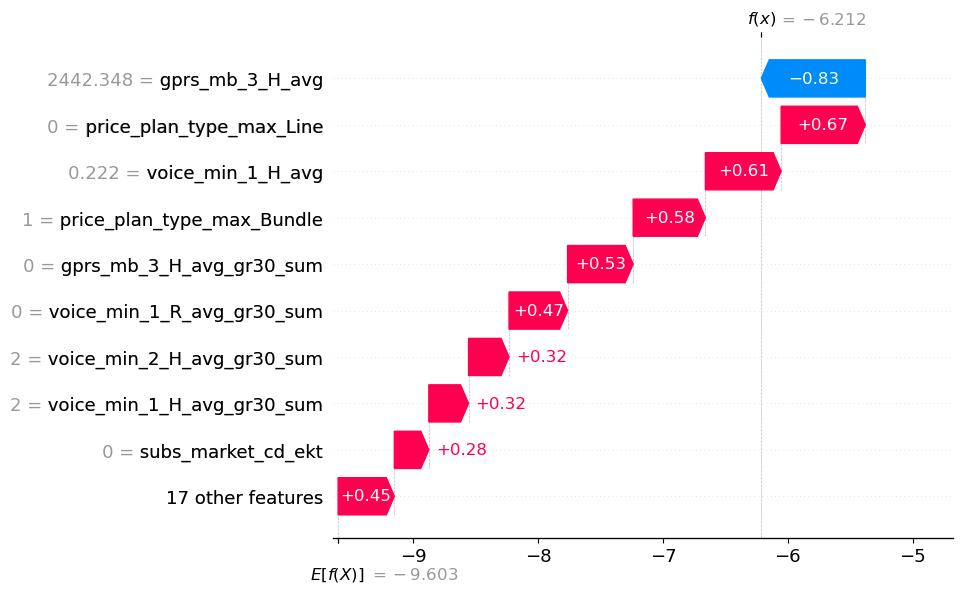

In [14]:
# import shap

explainer = shap.TreeExplainer(clf_lgb)
shap_values = explainer.shap_values(df_pd[model_features])

explanation = shap.Explanation(
    values = shap_values,
    base_values = explainer.expected_value,
    data = df_pd[model_features].values,
    feature_names = model_features
)

shap.plots.waterfall(explanation[0])

In [15]:
def print_shap_explanation_detailed(shap_values, explainer, feature_names, data, instance_idx, threshold=0.001):

    shap_val = shap_values[instance_idx]
    base_value = explainer.expected_value
    actual_values = data.iloc[instance_idx] if hasattr(data, 'iloc') else data[instance_idx]
    
    prediction = base_value + shap_val.sum()
    
    feature_importance = sorted(zip(feature_names, shap_val, actual_values), 
                               key=lambda x: abs(x[1]), reverse=True)
    
    print("="*90)
    print(f"Для наблюдения #{instance_idx}")
    print("="*90)
    print(f"Базовое значение (средний прогноз): {base_value:.4f}")
    print(f"Фактический прогноз: {prediction:.4f}")
    print(f"Сумма SHAP значений: {shap_val.sum():.4f}")
    print("-"*90)
    
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
    strong_impact = [(f, v, a) for f, v, a in feature_importance if abs(v) > 0.1]
    medium_impact = [(f, v, a) for f, v, a in feature_importance if 0.01 <= abs(v) <= 0.1]
    weak_impact = [(f, v, a) for f, v, a in feature_importance if 0.001 <= abs(v) < 0.01]
    
    def print_feature_group(features, title, color):
        if features:
            print(f"\n{color}{BOLD}{title}:{END}")
            print(f"{'Признак':<30} {'Факт.знач':<15} {'Вклад':<12} {'Влияние':<10}")
            print("-"*70)
            for feature, shap_value, actual_value in features:
                if abs(shap_value) > threshold:
                    direction = "↑ УВЕЛИЧ" if shap_value > 0 else "↓ УМЕНЬШ"
                    impact_color = GREEN if shap_value > 0 else RED
                    
                    if isinstance(actual_value, float):
                        actual_str = f"{actual_value:.4f}"
                    else:
                        actual_str = str(actual_value)
                    
                    print(f"{feature:<30} {actual_str:<15} {impact_color}{shap_value:+.4f}{END} {direction:<10}")
    
    print_feature_group(strong_impact, "СИЛЬНОЕ ВЛИЯНИЕ (|вклад| > 0.1)", RED)
    print_feature_group(medium_impact, "СРЕДНЕЕ ВЛИЯНИЕ (0.01 ≤ |вклад| ≤ 0.1)", YELLOW) 
    print_feature_group(weak_impact, "СЛАБОЕ ВЛИЯНИЕ (0.001 ≤ |вклад| < 0.01)", BLUE)
    
    print("-"*90)
    

print_shap_explanation_detailed(shap_values, explainer, model_features, 
                                df_pd[model_features], instance_idx = 0)

#для строки 0 просто выводит значения

Для наблюдения #0
Базовое значение (средний прогноз): -9.6029
Фактический прогноз: -6.2122
Сумма SHAP значений: 3.3907
------------------------------------------------------------------------------------------

СИЛЬНОЕ ВЛИЯНИЕ (|вклад| > 0.1):
Признак                        Факт.знач       Вклад        Влияние   
----------------------------------------------------------------------
gprs_mb_3_H_avg                2442.3484       -0.8334 ↓ УМЕНЬШ  
price_plan_type_max_Line       0.0000          +0.6745 ↑ УВЕЛИЧ  
voice_min_1_H_avg              0.2222          +0.6071 ↑ УВЕЛИЧ  
price_plan_type_max_Bundle     1.0000          +0.5785 ↑ УВЕЛИЧ  
gprs_mb_3_H_avg_gr30_sum       0.0000          +0.5255 ↑ УВЕЛИЧ  
voice_min_1_R_avg_gr30_sum     0.0000          +0.4692 ↑ УВЕЛИЧ  
voice_min_2_H_avg_gr30_sum     2.0000          +0.3242 ↑ УВЕЛИЧ  
voice_min_1_H_avg_gr30_sum     2.0000          +0.3183 ↑ УВЕЛИЧ  
subs_market_cd_ekt             0.0000          +0.2762 ↑ УВЕЛИЧ  
subs_market_cd_kzn  

In [16]:
def create_shap_summary_df(shap_values, explainer, feature_names, data, client_ids=None, threshold=0.1):

    base_value = explainer.expected_value
    predictions = base_value + np.sum(shap_values, axis=1)
    
    results = []
    
    for instance_idx in range(len(data)):
        shap_val = shap_values[instance_idx]
        actual_values = data.iloc[instance_idx] if hasattr(data, 'iloc') else data[instance_idx]
        
        row_data = {
            'client_id': client_ids[instance_idx] if client_ids is not None else instance_idx,
            'Фактический_прогноз': predictions[instance_idx],
            'Базовое_значение': base_value,
            'Сумма_SHAP_значений': shap_val.sum()
        }
        
        strong_impact_features = []
        for feature, shap_value, actual_value in zip(feature_names, shap_val, actual_values):
            if abs(shap_value) > threshold:
                feature_key = f"{feature}_вклад"
                feature_value_key = f"{feature}_значение"
                row_data[feature_key] = shap_value
                row_data[feature_value_key] = actual_value
                strong_impact_features.append(feature)
        
        row_data['Признаки_с_сильным_влиянием'] = ', '.join(strong_impact_features)
        results.append(row_data)
    
    summary_df = pd.DataFrame(results)
    
    # base_columns = ['id', 'Фактический_прогноз', 'Базовое_значение', 'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием']
    base_columns = ['Фактический_прогноз', 'Базовое_значение', 'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием']
    feature_columns = [col for col in summary_df.columns if col not in base_columns]
    
    contribution_cols = [col for col in feature_columns if col.endswith('_вклад')]
    value_cols = [col for col in feature_columns if col.endswith('_значение')]
    
    contribution_cols.sort()
    value_cols.sort()
    
    final_columns = base_columns + contribution_cols + value_cols
    summary_df = summary_df[final_columns]
    
    return summary_df



summary_df = create_shap_summary_df(shap_values, explainer, model_features, 
                                    df_pd[model_features], 
                                    client_ids = df_pd.index)

#для всех значений выведет табл

In [36]:
# summary_df.columns

In [19]:
print(df_pd.shape)

print(summary_df.shape)
summary_df

(1145826, 29)
(1145826, 56)


,Фактический_прогноз,Базовое_значение,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,gprs_mb_3_H_avg_gr30_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,-6.212204,-9.60294,3.390736,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.147029,NaN,NaN,NaN,0.525526,...,NaN,NaN,2.0,0.222222,0.0,0.000000,2.0,0.000000,0.0,NaN
1,-5.016534,-9.60294,4.586406,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,-0.424609,-0.428637,NaN,-1.482759,-1.773523,...,NaN,NaN,NaN,0.288095,0.0,NaN,2.0,13.119047,NaN,NaN
2,-4.586339,-9.60294,5.016601,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",0.209366,-1.611182,-1.548590,NaN,NaN,0.461999,...,NaN,NaN,1.0,NaN,1.0,0.429167,1.0,2.264583,NaN,NaN
3,-6.240960,-9.60294,3.361980,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,0.103486,0.344416,...,NaN,1.0,1.0,2.990476,1.0,5.907143,1.0,3.369048,NaN,8.82381
4,-5.624513,-9.60294,3.978427,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,NaN,0.280675,...,NaN,NaN,1.0,1.863889,0.0,0.000000,2.0,1.544444,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145821,-3.289936,-9.60294,6.313004,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,-0.575396,-0.558497,NaN,0.219243,0.929072,...,NaN,NaN,2.0,0.845238,0.0,0.000000,1.0,NaN,NaN,NaN
1145822,-4.202866,-9.60294,5.400074,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,-1.268485,1.410063,...,NaN,NaN,1.0,6.780952,0.0,0.000000,1.0,14.423810,NaN,NaN
1145823,-3.261543,-9.60294,6.341397,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.266535,-0.616581,0.786437,NaN,NaN,-14.043520,...,NaN,NaN,0.0,15.207143,0.0,0.000000,1.0,11.707143,0.0,NaN
1145824,-6.661696,-9.60294,2.941244,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,NaN,NaN,0.152614,0.237818,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN


In [20]:
print(df_pd.shape)
print(summary_df.shape)

df_pd_shape = pd.concat([df_pd, summary_df], axis = 1)

print(df_pd_shape.shape)
df_pd_shape.head()

(1145826, 29)
(1145826, 56)
(1145826, 85)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,2221,43,0,2442.348389,2,0.000000,2,0,4.0,1,...,NaN,NaN,2.0,0.222222,0.0,0.000000,2.0,0.000000,0.0,NaN
1,4901,43,0,258.087158,1,0.000000,2,0,6.0,1,...,NaN,NaN,NaN,0.288095,0.0,NaN,2.0,13.119047,NaN,NaN
2,33608,43,1,3506.158691,1,0.429167,1,0,7.0,1,...,NaN,NaN,1.0,NaN,1.0,0.429167,1.0,2.264583,NaN,NaN
3,102242,43,0,0.000000,1,5.907143,1,0,0.0,1,...,NaN,1.0,1.0,2.990476,1.0,5.907143,1.0,3.369048,NaN,8.82381
4,109152,43,0,0.000000,1,0.000000,2,0,0.0,1,...,NaN,NaN,1.0,1.863889,0.0,0.000000,2.0,1.544444,NaN,NaN


##### Sorting

In [22]:
df_pd_shape.sort_values(by = 'score_ML', ascending = False, inplace = True)

print(df_pd_shape.shape)
df_pd_shape

# (1173744, 85)

(1145826, 85)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
473807,392614288,43,1,4536.025879,2,0.0,2,0,5.0,1,...,NaN,NaN,2.0,1.385714,2.0,0.0,2.0,1.997619,NaN,2.735714
258974,91661568,43,2,1.203333,1,0.0,1,0,2.0,0,...,NaN,0.0,1.0,7.588889,0.0,0.0,1.0,NaN,0.0,NaN
194896,14383489,43,1,0.178571,0,0.0,1,1,0.0,0,...,NaN,NaN,0.0,96.626190,0.0,0.0,1.0,25.214285,0.0,NaN
37157,286306664,43,0,3887.300049,1,0.0,1,0,6.0,1,...,NaN,NaN,1.0,0.273810,0.0,0.0,1.0,2.000000,NaN,NaN
122510,236300301,43,0,4.435268,0,0.0,2,1,1.0,0,...,NaN,NaN,0.0,17.497620,0.0,0.0,2.0,10.476191,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216820,465737660,43,0,1406.189941,1,0.0,2,0,6.0,0,...,NaN,NaN,1.0,3.088095,0.0,0.0,2.0,1.719048,0.0,NaN
767749,30640185,43,0,235.214081,0,0.0,0,1,6.0,0,...,NaN,NaN,0.0,6.407407,0.0,0.0,0.0,16.120371,0.0,NaN
280051,449879416,43,0,45.955715,1,0.0,0,0,4.0,0,...,NaN,0.0,1.0,8.533334,0.0,NaN,0.0,13.352381,0.0,NaN
1055314,161766094,43,1,0.164342,0,0.0,1,0,1.0,0,...,NaN,NaN,0.0,7.104762,0.0,0.0,1.0,2.397619,0.0,NaN


In [23]:
df_pd_shape.columns

Index(['subscriber_sk', 'week_of_year', 'gprs_mb_3_H_avg_gr30_sum',
       'gprs_mb_3_H_avg', 'voice_min_1_H_avg_gr30_sum', 'voice_min_1_R_avg',
       'voice_min_2_H_avg_gr30_sum', 'price_plan_type_max_Other',
       'active_days_sum', 'price_plan_type_max_Bundle', 'voice_min_2_H_avg',
       'voice_min_2_R_avg_gr30_sum', 'voice_min_1_H_avg', 'good_days_sum',
       'accept_days_sum', 'bad_days_sum', 'voice_min_1_R_avg_gr30_sum',
       'repr2q2025_max', 'subs_market_cd_vip', 'voice_min_2_R_avg',
       'price_plan_type_max_Line', 'subs_market_cd_ekt',
       'gprs_mb_3_R_avg_gr30_sum', 'subs_market_cd_kzn',
       'price_plan_type_max_Data', 'subs_market_cd_ufa', 'subs_market_cd_spb',
       'calls_sum', 'score_ML', 'Фактический_прогноз', 'Базовое_значение',
       'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием',
       'accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
       'calls_sum_вклад', 'good_days_sum_вклад',
       'gprs_mb_3_H_avg_gr30_sum_вклад',

In [24]:
df_pd_shape = df_pd_shape[['subscriber_sk', 'week_of_year', 'score_ML',
       # 'gprs_mb_3_H_avg_gr30_sum',
       # 'gprs_mb_3_H_avg', 'voice_min_1_H_avg_gr30_sum', 'voice_min_1_R_avg',
       # 'voice_min_2_H_avg_gr30_sum', 'price_plan_type_max_Other',
       # 'active_days_sum', 'price_plan_type_max_Bundle', 'voice_min_2_H_avg',
       # 'voice_min_2_R_avg_gr30_sum', 'voice_min_1_H_avg', 'good_days_sum',
       # 'accept_days_sum', 'bad_days_sum', 'voice_min_1_R_avg_gr30_sum',
       # 'repr2q2025_max', 'subs_market_cd_vip', 'voice_min_2_R_avg',
       # 'price_plan_type_max_Line', 'subs_market_cd_ekt',
       # 'gprs_mb_3_R_avg_gr30_sum', 'subs_market_cd_kzn',
       # 'price_plan_type_max_Data', 'subs_market_cd_ufa', 'subs_market_cd_spb',
       # 'calls_sum', 
       # 'Фактический_прогноз', 'Базовое_значение',
       'Сумма_SHAP_значений', 'Признаки_с_сильным_влиянием',
       'accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
       'calls_sum_вклад', 'good_days_sum_вклад',
       'gprs_mb_3_H_avg_gr30_sum_вклад', 'gprs_mb_3_H_avg_вклад',
       'gprs_mb_3_R_avg_gr30_sum_вклад', 'price_plan_type_max_Bundle_вклад',
       'price_plan_type_max_Data_вклад', 'price_plan_type_max_Line_вклад',
       'price_plan_type_max_Other_вклад', 'repr2q2025_max_вклад',
       'subs_market_cd_ekt_вклад', 'subs_market_cd_kzn_вклад',
       'subs_market_cd_spb_вклад', 'subs_market_cd_ufa_вклад',
       'subs_market_cd_vip_вклад', 'voice_min_1_H_avg_gr30_sum_вклад',
       'voice_min_1_H_avg_вклад', 'voice_min_1_R_avg_gr30_sum_вклад',
       'voice_min_1_R_avg_вклад', 'voice_min_2_H_avg_gr30_sum_вклад',
       'voice_min_2_H_avg_вклад', 'voice_min_2_R_avg_gr30_sum_вклад',
       'voice_min_2_R_avg_вклад', 'accept_days_sum_значение',
       'active_days_sum_значение', 'bad_days_sum_значение',
       'calls_sum_значение', 'good_days_sum_значение',
       'gprs_mb_3_H_avg_gr30_sum_значение', 'gprs_mb_3_H_avg_значение',
       'gprs_mb_3_R_avg_gr30_sum_значение',
       'price_plan_type_max_Bundle_значение',
       'price_plan_type_max_Data_значение',
       'price_plan_type_max_Line_значение',
       'price_plan_type_max_Other_значение', 'repr2q2025_max_значение',
       'subs_market_cd_ekt_значение', 'subs_market_cd_kzn_значение',
       'subs_market_cd_spb_значение', 'subs_market_cd_ufa_значение',
       'subs_market_cd_vip_значение', 'voice_min_1_H_avg_gr30_sum_значение',
       'voice_min_1_H_avg_значение', 'voice_min_1_R_avg_gr30_sum_значение',
       'voice_min_1_R_avg_значение', 'voice_min_2_H_avg_gr30_sum_значение',
       'voice_min_2_H_avg_значение', 'voice_min_2_R_avg_gr30_sum_значение',
       'voice_min_2_R_avg_значение']]

print(df_pd_shape.shape)
df_pd_shape.head()

# (1173744, 85)

(1145826, 57)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
473807,392614288,43,1.0,34.984071,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,2.363391,NaN,0.450859,...,NaN,NaN,2.0,1.385714,2.0,0.0,2.0,1.997619,NaN,2.735714
258974,91661568,43,1.0,54.862357,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.119589,NaN,NaN,NaN,...,NaN,0.0,1.0,7.588889,0.0,0.0,1.0,NaN,0.0,NaN
194896,14383489,43,1.0,237.374935,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.566869,NaN,NaN,NaN,2.135886,...,NaN,NaN,0.0,96.626190,0.0,0.0,1.0,25.214285,0.0,NaN
37157,286306664,43,1.0,35.041178,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,-0.611863,4.762087,NaN,0.637152,...,NaN,NaN,1.0,0.273810,0.0,0.0,1.0,2.000000,NaN,NaN
122510,236300301,43,1.0,41.646954,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.618611,0.161879,NaN,NaN,-5.746091,...,NaN,NaN,0.0,17.497620,0.0,0.0,2.0,10.476191,0.0,NaN


<Axes: >

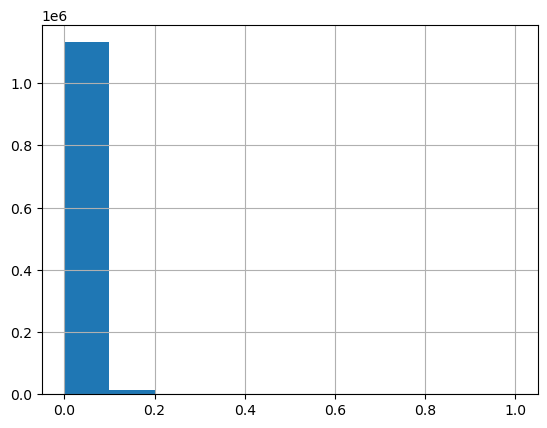

In [25]:
df_pd_shape['score_ML'].hist(bins = 10)

<Axes: >

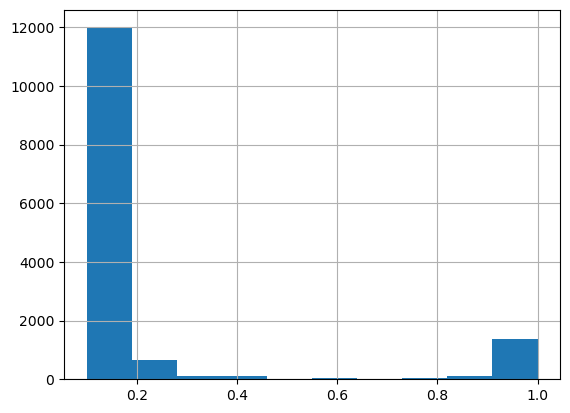

In [26]:
df_pd_shape[df_pd_shape['score_ML'] > 0.1]['score_ML'].hist(bins = 10)

<Axes: >

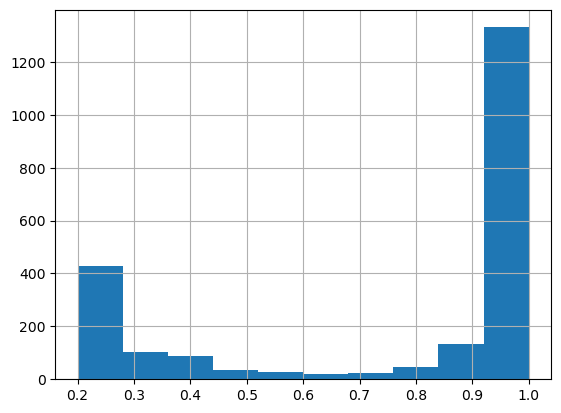

In [27]:
df_pd_shape[df_pd_shape['score_ML'] > 0.2]['score_ML'].hist(bins = 10)

In [28]:
# 1 - входящий;
# 2 - исходящий;

df_top_ml_300 = df_pd_shape.iloc[:300, :]

df_top_ml_300 = df_top_ml_300.reset_index(drop = True)

print(df_top_ml_300.shape)
df_top_ml_300.head()

(300, 57)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,392614288,43,1.0,34.984071,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,2.363391,NaN,0.450859,...,NaN,NaN,2.0,1.385714,2.0,0.0,2.0,1.997619,NaN,2.735714
1,91661568,43,1.0,54.862357,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.119589,NaN,NaN,NaN,...,NaN,0.0,1.0,7.588889,0.0,0.0,1.0,NaN,0.0,NaN
2,14383489,43,1.0,237.374935,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.566869,NaN,NaN,NaN,2.135886,...,NaN,NaN,0.0,96.626190,0.0,0.0,1.0,25.214285,0.0,NaN
3,286306664,43,1.0,35.041178,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,-0.611863,4.762087,NaN,0.637152,...,NaN,NaN,1.0,0.273810,0.0,0.0,1.0,2.000000,NaN,NaN
4,236300301,43,1.0,41.646954,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.618611,0.161879,NaN,NaN,-5.746091,...,NaN,NaN,0.0,17.497620,0.0,0.0,2.0,10.476191,0.0,NaN


In [29]:
# dict_vars = {'gprs_mb_3_H_avg_gr30_sum': 'Домашний дата трафик (тригер падения на 30%)',
#                 'gprs_mb_3_H_avg': 'Домашний дата трафик ',
#                 'voice_min_1_H_avg_gr30_sum': 'Домашний входящий голосовой трафик (тригер падения на 30%)',
#                 'voice_min_1_R_avg': 'Роуминговый входящий голосовой трафик ',
#                 'voice_min_2_H_avg_gr30_sum': 'Домашний исходящий голосовой трафик (тригер падения на 30%)',
#                 'price_plan_type_max_Other': 'Тип тарифного плана ("Other")',
#                 'active_days_sum': 'Кол-во активных дней',
#                 'price_plan_type_max_Bundle': 'Тип тарифного плана ("Bundle")',
#                 'voice_min_2_H_avg': 'Домашний исходящий голосовой трафик',
#                 'voice_min_2_R_avg_gr30_sum': 'Роуминговый исходящий голосовой трафик (тригер падения на 30%)',
#                 'voice_min_1_H_avg': 'Домашний входящий голосовой трафик ',
#                 'good_days_sum': 'Кол-во хороших дней (качество интернет сети)',
#                 'accept_days_sum': 'Кол-во приемлемых дней (качество интернет сети)',
#                 'bad_days_sum': 'Кол-во плохих дней (качество интернет сети)',
#                 'voice_min_1_R_avg_gr30_sum': 'Роуминговый входящий голосовой трафик  (тригер падения на 30%)',
#                 'repr2q2025_max': 'Флаг попадания в репрайс во 2 квартале 2025 года',
#                 'subs_market_cd_vip': 'Регион (Москва)',
#                 'voice_min_2_R_avg': 'Роуминговый исходящий голосовой трафик ',
#                 'price_plan_type_max_Line': 'Тип тарифного плана ("Line")',
#                 'subs_market_cd_ekt': 'Регион (Екатеринбург)',
#                 'gprs_mb_3_R_avg_gr30_sum': 'Роуминговый дата трафик (тригер падения на 30%)',
#                 'subs_market_cd_kzn': 'Регион (Казань)',
#                 'price_plan_type_max_Data': 'Тип тарифного плана ("Data")',
#                 'subs_market_cd_ufa': 'Регион (Уфа)',
#                 'subs_market_cd_spb': 'Регион (СПБ)',
#                 'calls_sum': 'Кол-во звонков'
#             }

In [30]:
dict_vars = {'gprs_mb_3_H_avg_gr30_sum': 'Домашний дата трафик, падение на 30%',
                'gprs_mb_3_H_avg': 'Домашний дата трафик, низний уровень',
                'voice_min_1_H_avg_gr30_sum': 'Домашний входящий голосовой трафик, падение на 30%',
                'voice_min_1_R_avg': '',
                'voice_min_2_H_avg_gr30_sum': 'Домашний исходящий голосовой трафик, падение на 30%',
                'price_plan_type_max_Other': '',
                'active_days_sum': 'Кол-во дней активности',
                'price_plan_type_max_Bundle': '',
                'voice_min_2_H_avg': 'Домашний исходящий голосовой трафик, падение на 30%',
                'voice_min_2_R_avg_gr30_sum': '',
                'voice_min_1_H_avg': 'Домашний входящий голосовой трафик, низний уровень',
                'good_days_sum': 'Динамика хороших дней по качеству интернет сети',
                'accept_days_sum': 'Динамика приемлемых дней по качеству интернет сети',
                'bad_days_sum': 'Динамика плохих дней по качеству интернет сети',
                'voice_min_1_R_avg_gr30_sum': '',
                'repr2q2025_max': 'Флаг попадания в репрайс во 2 квартале 2025 года',
                'subs_market_cd_vip': '',
                'voice_min_2_R_avg': '',
                'price_plan_type_max_Line': '',
                'subs_market_cd_ekt': '',
                'gprs_mb_3_R_avg_gr30_sum': '',
                'subs_market_cd_kzn': '',
                'price_plan_type_max_Data': '',
                'subs_market_cd_ufa': '',
                'subs_market_cd_spb': '',
                'calls_sum': 'Кол-во звонков'
            }

In [31]:
# df_top_ml_300.info()

In [37]:
vars_cons = ['accept_days_sum_вклад', 'active_days_sum_вклад', 'bad_days_sum_вклад',
               'calls_sum_вклад', 'good_days_sum_вклад',
               'gprs_mb_3_H_avg_gr30_sum_вклад', 'gprs_mb_3_H_avg_вклад',
               'gprs_mb_3_R_avg_gr30_sum_вклад', 'price_plan_type_max_Bundle_вклад',
               'price_plan_type_max_Data_вклад', 'price_plan_type_max_Line_вклад',
               'price_plan_type_max_Other_вклад', 'repr2q2025_max_вклад',
               'subs_market_cd_ekt_вклад', 'subs_market_cd_kzn_вклад',
               'subs_market_cd_spb_вклад', 'subs_market_cd_ufa_вклад',
               'subs_market_cd_vip_вклад', 'voice_min_1_H_avg_gr30_sum_вклад',
               'voice_min_1_H_avg_вклад', 'voice_min_1_R_avg_gr30_sum_вклад',
               'voice_min_1_R_avg_вклад', 'voice_min_2_H_avg_gr30_sum_вклад',
               'voice_min_2_H_avg_вклад', 'voice_min_2_R_avg_gr30_sum_вклад',
               'voice_min_2_R_avg_вклад']

list_sk = list(df_top_ml_300['subscriber_sk'])
rows = []
n = 0

# for i in [342859481]:
# for i in [342859481, 262475856, 211229009]:
for i in list_sk:

    vars_top7 = pd.DataFrame(df_top_ml_300[df_top_ml_300['subscriber_sk'] == i][vars_cons].T, columns = [n])
    vars_top7 = vars_top7.sort_values(n, ascending = False)
    # print(vars_top7)
    n += 1
    
    vars_top7 = list(vars_top7[:7].index)

    vars_top7_str = ''
    for j in range(7):
        var = vars_top7[j][:-6]
        var = dict_vars.get(var, var)
        # vars_top7_str += var + ', '
        if j < 4:
            vars_top7_str += var + ', '
        else:
            vars_top7_str += var
    
    row = {
        'subscriber_sk': i,
        'top_7_признаков_с_сильным_влиянием': vars_top7_str
    }
    rows.append(row)

# Convert to DataFrame after the loop
df_top7 = pd.DataFrame(rows)
df_top7

,subscriber_sk,top_7_признаков_с_сильным_влиянием
0,392614288,"Домашний исходящий голосовой трафик, падение н..."
1,91661568,"Домашний дата трафик, низний уровень, Домашний..."
2,14383489,"Домашний дата трафик, низний уровень, Домашний..."
3,286306664,"Домашний исходящий голосовой трафик, падение н..."
4,236300301,"Домашний исходящий голосовой трафик, падение н..."
...,...,...
295,453648477,", Домашний входящий голосовой трафик, низний у..."
296,373598468,"Домашний дата трафик, падение на 30%, Домашний..."
297,35691850,"Домашний исходящий голосовой трафик, падение н..."
298,381606346,", Домашний входящий голосовой трафик, низний у..."


In [38]:
df_top_ml_300['top_7_признаков_с_сильным_влиянием'] = df_top7['top_7_признаков_с_сильным_влиянием']

print(df_top_ml_300.shape)
df_top_ml_300.head(3)

(300, 59)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,good_days_sum_вклад,...,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение,top_5_признаков_с_сильным_влиянием,top_7_признаков_с_сильным_влиянием
0,392614288,43,1.0,34.984071,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,2.363391,NaN,0.450859,...,2.0,1.385714,2.0,0.0,2.0,1.997619,NaN,2.735714,"Домашний исходящий голосовой трафик, падение н...","Домашний исходящий голосовой трафик, падение н..."
1,91661568,43,1.0,54.862357,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.119589,NaN,NaN,NaN,...,1.0,7.588889,0.0,0.0,1.0,NaN,0.0,NaN,"Домашний дата трафик, низний уровень, Домашний...","Домашний дата трафик, низний уровень, Домашний..."
2,14383489,43,1.0,237.374935,"gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.566869,NaN,NaN,NaN,2.135886,...,0.0,96.626190,0.0,0.0,1.0,25.214285,0.0,NaN,"Домашний дата трафик, низний уровень, Домашний...","Домашний дата трафик, низний уровень, Домашний..."


In [39]:
df_top_ml_300.columns

Index(['subscriber_sk', 'week_of_year', 'score_ML', 'Сумма_SHAP_значений',
       'Признаки_с_сильным_влиянием', 'accept_days_sum_вклад',
       'active_days_sum_вклад', 'bad_days_sum_вклад', 'calls_sum_вклад',
       'good_days_sum_вклад', 'gprs_mb_3_H_avg_gr30_sum_вклад',
       'gprs_mb_3_H_avg_вклад', 'gprs_mb_3_R_avg_gr30_sum_вклад',
       'price_plan_type_max_Bundle_вклад', 'price_plan_type_max_Data_вклад',
       'price_plan_type_max_Line_вклад', 'price_plan_type_max_Other_вклад',
       'repr2q2025_max_вклад', 'subs_market_cd_ekt_вклад',
       'subs_market_cd_kzn_вклад', 'subs_market_cd_spb_вклад',
       'subs_market_cd_ufa_вклад', 'subs_market_cd_vip_вклад',
       'voice_min_1_H_avg_gr30_sum_вклад', 'voice_min_1_H_avg_вклад',
       'voice_min_1_R_avg_gr30_sum_вклад', 'voice_min_1_R_avg_вклад',
       'voice_min_2_H_avg_gr30_sum_вклад', 'voice_min_2_H_avg_вклад',
       'voice_min_2_R_avg_gr30_sum_вклад', 'voice_min_2_R_avg_вклад',
       'accept_days_sum_значение', 'activ

In [41]:
df_top_ml_300 = df_top_ml_300[['subscriber_sk', 'week_of_year', 'score_ML', 'Сумма_SHAP_значений',
                               'top_7_признаков_с_сильным_влиянием',
                               'Признаки_с_сильным_влиянием', 'accept_days_sum_вклад',
                               'active_days_sum_вклад', 'bad_days_sum_вклад', 'calls_sum_вклад',
                               'good_days_sum_вклад', 'gprs_mb_3_H_avg_gr30_sum_вклад',
                               'gprs_mb_3_H_avg_вклад', 'gprs_mb_3_R_avg_gr30_sum_вклад',
                               'price_plan_type_max_Bundle_вклад', 'price_plan_type_max_Data_вклад',
                               'price_plan_type_max_Line_вклад', 'price_plan_type_max_Other_вклад',
                               'repr2q2025_max_вклад', 'subs_market_cd_ekt_вклад',
                               'subs_market_cd_kzn_вклад', 'subs_market_cd_spb_вклад',
                               'subs_market_cd_ufa_вклад', 'subs_market_cd_vip_вклад',
                               'voice_min_1_H_avg_gr30_sum_вклад', 'voice_min_1_H_avg_вклад',
                               'voice_min_1_R_avg_gr30_sum_вклад', 'voice_min_1_R_avg_вклад',
                               'voice_min_2_H_avg_gr30_sum_вклад', 'voice_min_2_H_avg_вклад',
                               'voice_min_2_R_avg_gr30_sum_вклад', 'voice_min_2_R_avg_вклад',
                               'accept_days_sum_значение', 'active_days_sum_значение',
                               'bad_days_sum_значение', 'calls_sum_значение', 'good_days_sum_значение',
                               'gprs_mb_3_H_avg_gr30_sum_значение', 'gprs_mb_3_H_avg_значение',
                               'gprs_mb_3_R_avg_gr30_sum_значение',
                               'price_plan_type_max_Bundle_значение',
                               'price_plan_type_max_Data_значение',
                               'price_plan_type_max_Line_значение',
                               'price_plan_type_max_Other_значение', 'repr2q2025_max_значение',
                               'subs_market_cd_ekt_значение', 'subs_market_cd_kzn_значение',
                               'subs_market_cd_spb_значение', 'subs_market_cd_ufa_значение',
                               'subs_market_cd_vip_значение', 'voice_min_1_H_avg_gr30_sum_значение',
                               'voice_min_1_H_avg_значение', 'voice_min_1_R_avg_gr30_sum_значение',
                               'voice_min_1_R_avg_значение', 'voice_min_2_H_avg_gr30_sum_значение',
                               'voice_min_2_H_avg_значение', 'voice_min_2_R_avg_gr30_sum_значение',
                               'voice_min_2_R_avg_значение']]

In [42]:
print(df_top_ml_300.shape)
df_top_ml_300.head(3)

(300, 58)


,subscriber_sk,week_of_year,score_ML,Сумма_SHAP_значений,top_7_признаков_с_сильным_влиянием,Признаки_с_сильным_влиянием,accept_days_sum_вклад,active_days_sum_вклад,bad_days_sum_вклад,calls_sum_вклад,...,subs_market_cd_ufa_значение,subs_market_cd_vip_значение,voice_min_1_H_avg_gr30_sum_значение,voice_min_1_H_avg_значение,voice_min_1_R_avg_gr30_sum_значение,voice_min_1_R_avg_значение,voice_min_2_H_avg_gr30_sum_значение,voice_min_2_H_avg_значение,voice_min_2_R_avg_gr30_sum_значение,voice_min_2_R_avg_значение
0,392614288,43,1.0,34.984071,"Домашний исходящий голосовой трафик, падение н...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,NaN,2.363391,NaN,...,NaN,NaN,2.0,1.385714,2.0,0.0,2.0,1.997619,NaN,2.735714
1,91661568,43,1.0,54.862357,"Домашний дата трафик, низний уровень, Домашний...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",NaN,0.119589,NaN,NaN,...,NaN,0.0,1.0,7.588889,0.0,0.0,1.0,NaN,0.0,NaN
2,14383489,43,1.0,237.374935,"Домашний дата трафик, низний уровень, Домашний...","gprs_mb_3_H_avg_gr30_sum, gprs_mb_3_H_avg, voi...",-0.566869,NaN,NaN,NaN,...,NaN,NaN,0.0,96.626190,0.0,0.0,1.0,25.214285,0.0,NaN


<Axes: >

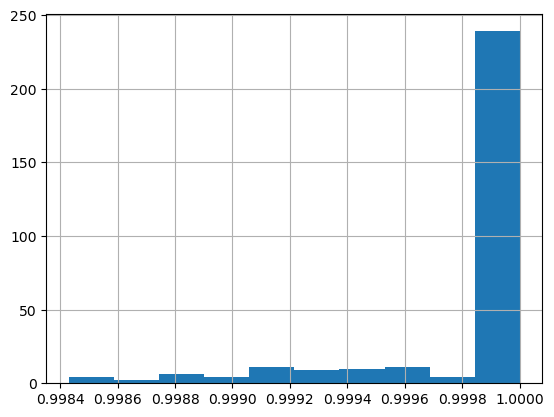

In [43]:
df_top_ml_300['score_ML'].hist()

In [44]:
df_top_ml_300.to_excel('df_top_ml_300_features_shape_week_43.xlsx')